# Background

**Example 4.3**: Gambler’s Problem A gambler has the opportunity to make bets on the outcomes
of a sequence of coin flips. If the coin comes up heads, he wins as many dollars as he has staked on
that flip; if it is tails, he loses his stake. The game ends when the gambler wins by reaching his goal
of \\$100, or loses by running out of money. On each flip, the gambler must decide what portion of his
capital to stake, in integer numbers of dollars. This problem can be formulated as an undiscounted,
episodic, finite MDP. The state is the gambler’s capital, $s\in\{1,\dots,99\}$ and the actions are stakes,
$a\in\{1,\dots,\min(1, 100-s)$. The reward is zero on all transitions except those on which the gambler
reaches his goal, when it is +1. The state-value function then gives the probability of winning from
each state. A policy is a mapping from levels of capital to stakes. The optimal policy maximizes
the probability of reaching the goal. Let $p_h$ denote the probability of the coin coming up heads. If
$p_h$ is known, then the entire problem is known and it can be solved, for instance, by value iteration.
Figure 4.3 shows the change in the value function over successive sweeps of value iteration, and the final
policy found, for the case of $p_h = 0.4$. This policy is optimal, but not unique. In fact, there is a whole
family of optimal policies, all corresponding to ties for the argmax action selection with respect to the
optimal value function. Can you guess what the entire family looks like?

![](gamplers_problem.png)

**Figure 4.3**: The solution to the gambler’s problem for $p_h = 0.4$. The upper graph shows the value function
found by successive sweeps of value iteration. The lower graph shows the final policy.

# Code

In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

PROBABILITY_HEADS = 0.4
GOAL = 100
STATES = np.arange(GOAL + 1)
THETA = 1e-06
GAMMA = 1
WITHOUT_ZERO_ACTION = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
def actions(state):
    """The actions available at a given state.
    """
    return np.arange(min(state, GOAL - state) + 1)


def reward(s):
    """Reward at a given state.
    """
    if s == 100:
        return 1
    return 0


def sigma(state_value, state):
    """A list of each sum in the max and argmax of the algorithm, page 67.
    """
    action_value = []
    for action in actions(state):
        action_value.append(
            PROBABILITY_HEADS * (reward(state) + GAMMA * state_value[state + action]) + 
            (1 - PROBABILITY_HEADS) * (reward(state) + GAMMA * state_value[state - action])
        )
    return np.array(action_value)


def optimal_policy(state_value, state, without_zero_action=WITHOUT_ZERO_ACTION):
    """Use the state and state_value to infer the optimal policy.
    
    The without_zero_action drops the 0 action, e.g. action of not betting,
    and rounds to 5th decimal. This was seemingly done in the example in
    the book.
    """
    if without_zero_action:
        return np.argmax(np.round(sigma(state_value, state), 5)[1:]) + 1
    return np.argmax(sigma(state_value, state))


def value_iteration_example(keep_terminal_states=False):
    """Do the value iteration for the example.
    """

    # Initialize states.
    state_value = np.zeros(GOAL + 1)
    state_value[GOAL] = 1.0
    
    # Calculate the value function.
    while True:
        old_state_value = state_value.copy()
        for state in STATES[1:-1]:
            state_value[state] = np.max(sigma(state_value, state))

        delta = abs(old_state_value - state_value).max()
        if delta < THETA:
            break

    # Calculate the policy function.
    policy = np.zeros(GOAL + 1)
    for state in STATES[1:-1]:
        policy[state] = optimal_policy(state_value, state, without_zero_action=True)
        
    if keep_terminal_states:
        return state_value, policy
    
    # Take the subset of states {1, ... , 99}
    state_value = state_value[1:-1]
    policy = policy[1:-1]
    return state_value, policy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def visualize_results(state_value, policy):
    """Visualize the result of running the algorithm.
    """
    plt.figure(figsize=(7.5,5))
    plt.subplot(121)
    plt.title('State value function.')
    plt.plot(state_value)
    plt.subplot(122)
    plt.title('Policy function.')
    plt.plot(policy, '*')

In [34]:
# Test `actions()`.
assert actions(0) == [0], 'State 100 should be a recurrent state.'
assert actions(100) == [0], 'State 100 should be a recurrent state.'
for s in STATES:
    assert 0 in actions(s), '0 is always and action.'
    for a in actions(s):
        assert 0 <= a <= GOAL, 'The new state should be one of 0, ..., len(STATES).'
            

# Test `value_iteration_example()`.
state_value, policy = value_iteration_example(keep_terminal_states=True)
assert state_value[0] == 0, 'The state value function at state 0 should be 0.'
assert state_value[100] == 1, 'The state value function at state 100 should be 1.'
assert all([0<=v<=1 for v in state_value]), 'The expected value cannot be bigger than 1.'

# Exercise 4.9 (programming)
Implement value iteration for the gambler’s problem and solve it for
$p_h = 0.25$ and $p_h = 0.55$. In programming, you may find it convenient to introduce two dummy states
corresponding to termination with capital of 0 and 100, giving them values of 0 and 1 respectively.
Show your results graphically, as in Figure 4.3. Are your results stable as $\theta \rightarrow 0$?

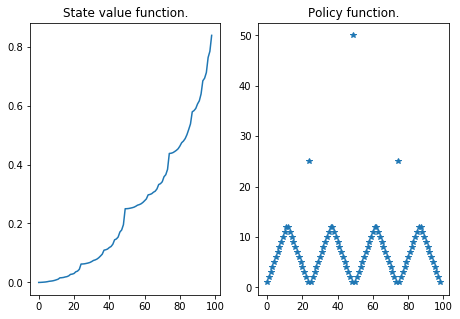

In [38]:
PROBABILITY_HEADS = 0.25

state_value, policy = value_iteration_example()
visualize_results(state_value, policy)

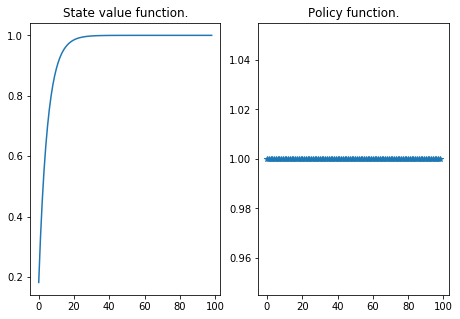

In [43]:
PROBABILITY_HEADS = 0.55

state_value, policy = value_iteration_example()
visualize_results(state_value, policy)

It seems stable as $\theta \rightarrow 0$.

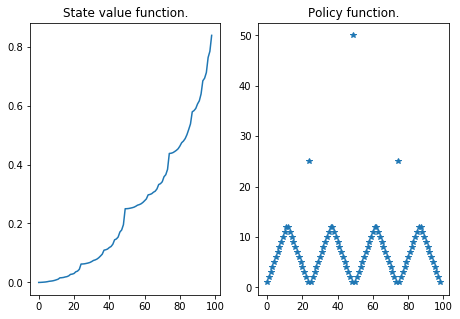

In [47]:
PROBABILITY_HEADS = 0.25
THETA = 1e-90

state_value, policy = value_iteration_example()
visualize_results(state_value, policy)